In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from src.evaluate_regression import get_rankings, average_spearman


sns.set_theme(style="whitegrid")
sns.set_palette(palette="Set2")

np.random.seed(7)

In [2]:
# Constants for supervisors functions
FACTORS = ["dataset", "model", "tuning", "scoring"]
NEW_INDEX = "encoder"
TARGET = "cv_score"

# Load Data

In [3]:
print("Loading processed train and validation set ...")

X_train = pd.read_csv("../../data/preprocessed/X_train.csv")
y_train = pd.read_csv("../../data/preprocessed/y_train.csv")
X_val = pd.read_csv("../../data/preprocessed/X_val.csv")
X_val_original = pd.read_csv("../../data/preprocessed/X_val_original.csv")
y_val = pd.read_csv("../../data/preprocessed/y_val.csv")

print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_val", X_val.shape)
print("Shape of X_val_original", X_val_original.shape)
print("Shape of y_val", y_val.shape)

Loading processed train and validation set ...
Shape of X_train (26989, 112)
Shape of y_train (26989, 1)
Shape of X_val (9065, 112)
Shape of X_val_original (9065, 5)
Shape of y_val (9065, 1)


In [4]:
X_train.head(5)

,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,non_categorical_features_count,ratio_of_categorical_features_to_all,sum_of_all_categories,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,total_feature_count,min_number_of_categories_per_cat_feature,max_number_of_categories_per_cat_feature,avg_number_of_categories_per_cat_feature
0,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
1,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
2,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
3,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
4,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681


# Testing different baseline models

In [5]:
def get_average_spearman(X_val_original, y_val, y_pred) -> float:

    df_pred = pd.concat([X_val_original, y_val, y_pred], axis=1)
    rankings_test = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score")
    rankings_pred = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score_pred")
    avg_spearman = average_spearman(rankings_test, rankings_pred)

    return avg_spearman

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

#######################################################
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
dt = DecisionTreeRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lassocv = LassoCV(n_jobs=-1, random_state=42, max_iter=20000)
mlp = MLPRegressor(random_state=42)
svr = SVR()

models = [rf, dt, xgb, lassocv, mlp, svr]
#######################################################

def fit_and_predict(models: list, X_train, y_train, X_val, y_val, X_val_original, model_types: str):

    model_string_list = []
    spearman_list = []
    fitted_models = []
    fit_time = []
    pred_scoring_time = []  # Contains time taken for prediction AND average spearman scoring only!
    mse = []
    r2 = []

    for model in models:
        model_string = str(model).split("(")[0]
        model_string_list.append(model_string)
        print(f"Fitting {model_string} ...")
        start = time.time()
        # Fit model
        model.fit(X_train, y_train.values.flatten())
        fit_time.append(np.round((time.time() - start), 4))

        # Predicting
        start = time.time()
        print("Making prediction on validation set ...")
        y_pred = pd.DataFrame(model.predict(X_val), columns=["cv_score_pred"])

        # Scoring
        print("Get average spearman score ...")
        spearman = get_average_spearman(X_val_original, y_val, y_pred)
        print(f"Average spearman score: {spearman:.4f}")

        pred_scoring_time.append(np.round((time.time() - start), 4))

        print("Append results ...\n")
        spearman_list.append(spearman)
        fitted_models.append(model)
        mse.append(mean_squared_error(y_true=y_val, y_pred=y_pred))
        r2.append(r2_score(y_true=y_val, y_pred=y_pred))

    # Build result dataframe
    res = pd.DataFrame({
        "fit_time": fit_time,
        "pred_scoring_time": pred_scoring_time,
        "average_spearman": spearman_list,
        "mse": mse,
        "r2": r2,
        "model_type": model_types
    }, index=model_string_list)

    return res, fitted_models


In [7]:
res, fitted_models = fit_and_predict(models, X_train, y_train, X_val, y_val, X_val_original, model_types="baseline")
res

Fitting RandomForestRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.5426
Append results ...

Fitting DecisionTreeRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.5061
Append results ...

Fitting XGBRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4115
Append results ...

Fitting LassoCV ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0850
Append results ...

Fitting MLPRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.2020
Append results ...

Fitting SVR ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.2223
Append results ...



,fit_time,pred_scoring_time,average_spearman,mse,r2,model_type
RandomForestRegressor,19.6847,1.5876,0.542645,0.004722,0.908113,baseline
DecisionTreeRegressor,0.7763,1.4877,0.506089,0.007293,0.858075,baseline
XGBRegressor,9.9737,2.4388,0.411495,0.003308,0.935633,baseline
LassoCV,22.4509,1.7672,0.085040,0.023994,0.533084,baseline
MLPRegressor,7.6276,1.8119,0.201974,0.010405,0.797528,baseline
SVR,18.5024,10.3539,0.222268,0.013685,0.733685,baseline


In [31]:
def plot_results(df):
    col_list = [column for column in res.columns if column != "model_type"]

    for col in col_list:
        fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=128)
        plt.title(f"Comparison of feature '{col}' of different models on hold-out-set", size=14)
        if len(df.model_type.unique()) > 1:
            g = sns.barplot(data=df.sort_values([col], ascending=False), y=df.index, x=col, edgecolor="black", hue="model_type", errorbar=None)
        else:
            g = sns.barplot(data=df.sort_values([col], ascending=False), y=df.index, x=col, edgecolor="black", errorbar=None)
        plt.show()

In [28]:
#plot_results(res)

# Testing different models after Feature Selection

In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

def fe_using_mi(X_train, y_train, num_features = 40, verbosity=0):
    # Perform feature selection using Mutual Information Regression
    selector = SelectKBest(mutual_info_regression, k=num_features)
    X_new = selector.fit_transform(X_train, y_train.values.flatten())


    # Get the indices of the selected features
    selected_features_indices = selector.get_support(indices=True)
    selected_features_names = selector.get_feature_names_out()
    selected_features_names = list(selected_features_names)

    # Append enc dim again
    X_new = pd.DataFrame(X_new, columns=selected_features_names, index=X_train.index)

    if verbosity > 0:
        # Print the selected features
        print("Selected Features:")
        for feature_name in selected_features_names:
            print(f"- {feature_name}")

    return X_new, selected_features_names

X_train_fe_mi, selected_features = fe_using_mi(X_train, y_train, num_features=40)
print("Shape of feature selected X_train ", X_train_fe_mi.shape)

X_val_fe_mi = X_val[selected_features]

Shape of feature selected X_train  (26989, 40)


,dataset,Dimensionality,Quartile2MutualInformation,Quartile2AttributeEntropy,MinorityClassSize,MajorityClassPercentage,NumberOfBinaryFeatures,Quartile1MutualInformation,EquivalentNumberOfAtts,MaxMutualInformation,...,Quartile3AttributeEntropy,row_count,column_count,categorical_features_count,non_categorical_features_count,ratio_of_categorical_features_to_all,sum_of_all_categories,total_feature_count,max_number_of_categories_per_cat_feature,avg_number_of_categories_per_cat_feature
0,0.025297,0.008425,0.005355,0.23511,0.011131,0.884197,0.102041,0.001394,0.000087,0.176262,...,1.0,0.049905,0.476695,0.274074,0.564327,0.045059,1.0,0.476695,0.705853,0.429681
1,0.025297,0.008425,0.005355,0.23511,0.011131,0.884197,0.102041,0.001394,0.000087,0.176262,...,1.0,0.049905,0.476695,0.274074,0.564327,0.045059,1.0,0.476695,0.705853,0.429681
2,0.025297,0.008425,0.005355,0.23511,0.011131,0.884197,0.102041,0.001394,0.000087,0.176262,...,1.0,0.049905,0.476695,0.274074,0.564327,0.045059,1.0,0.476695,0.705853,0.429681


In [11]:
res_fe, fitted_models_fe = fit_and_predict(models, X_train_fe_mi, y_train, X_val_fe_mi, y_val, X_val_original, model_types="fe_using_mi")

Fitting RandomForestRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0000
Append results ...

Fitting DecisionTreeRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0000
Append results ...

Fitting XGBRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0000
Append results ...

Fitting LassoCV ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0000
Append results ...

Fitting MLPRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0000
Append results ...

Fitting SVR ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0000
Append results ...



,fit_time,pred_scoring_time,average_spearman,mse,r2,model_type
RandomForestRegressor,2.1039,1.0240,0.0,0.027627,0.462391,fe_using_mi
DecisionTreeRegressor,0.0617,0.9476,0.0,0.027686,0.461234,fe_using_mi
XGBRegressor,1.1678,1.0026,0.0,0.027686,0.461240,fe_using_mi
LassoCV,7.5342,0.9189,0.0,0.031605,0.384976,fe_using_mi
MLPRegressor,1.3256,0.9897,0.0,0.029893,0.418280,fe_using_mi


In [33]:
#plot_results(res_fe)

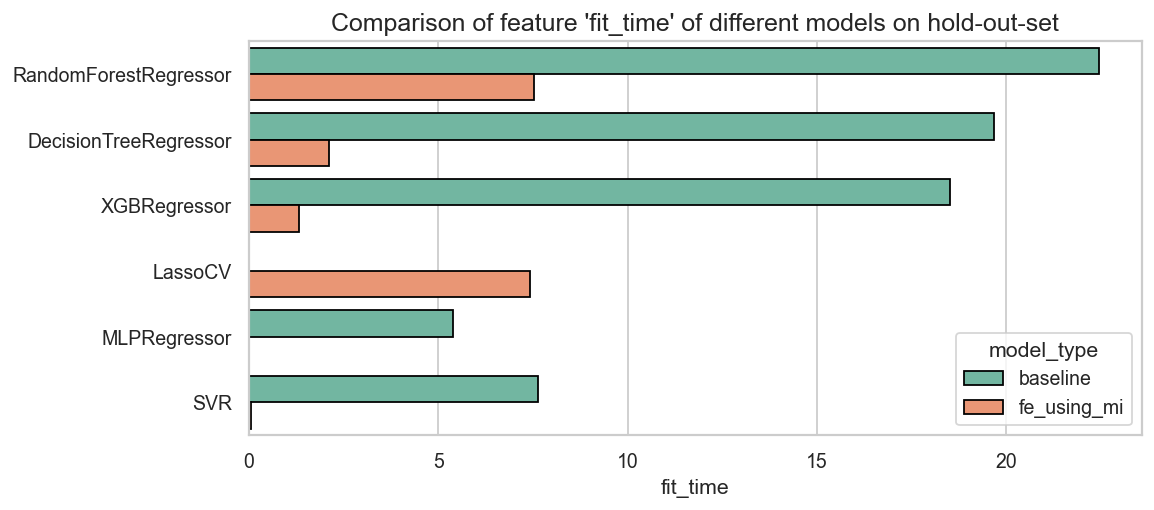

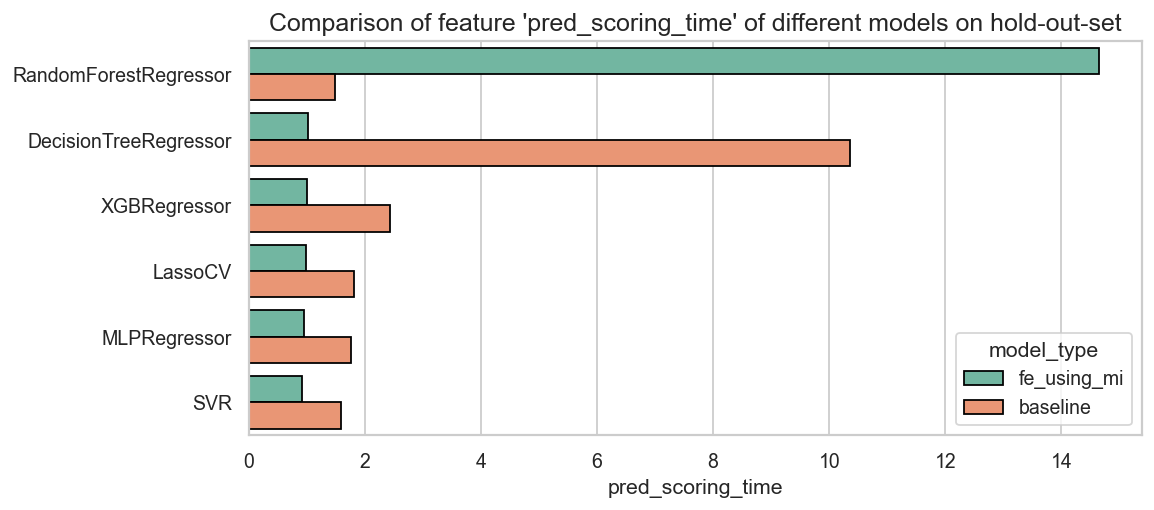

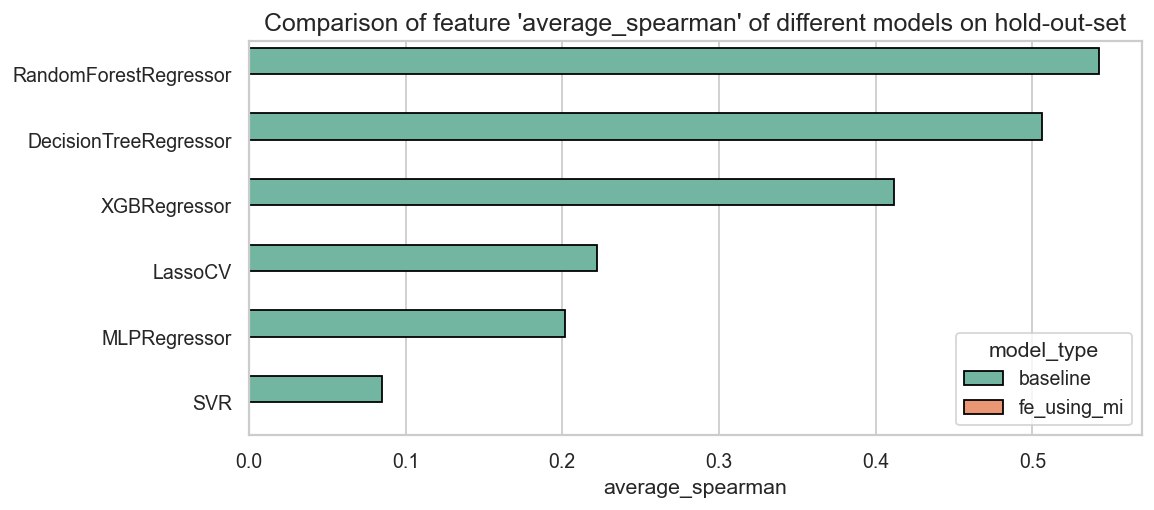

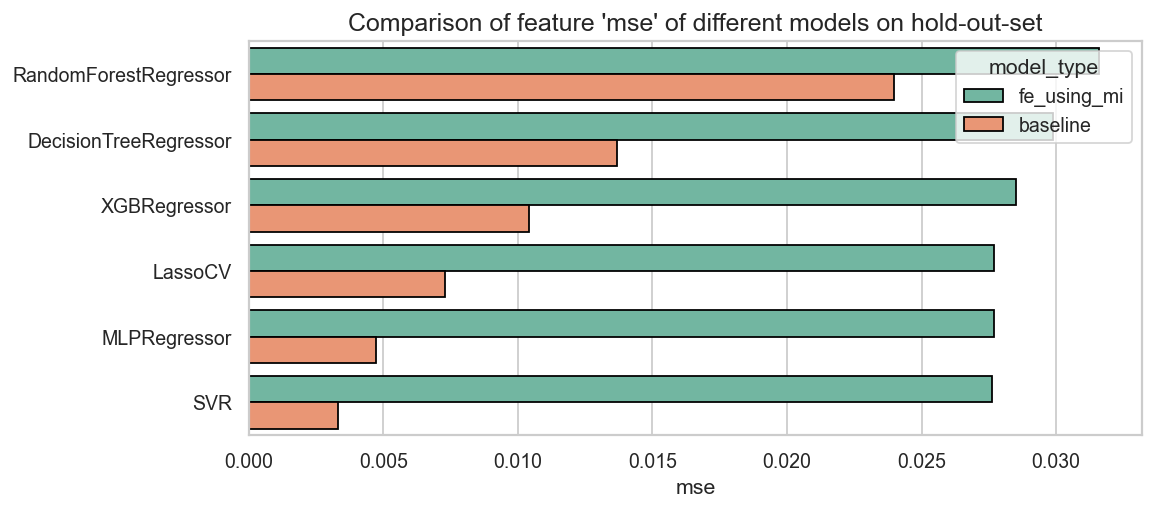

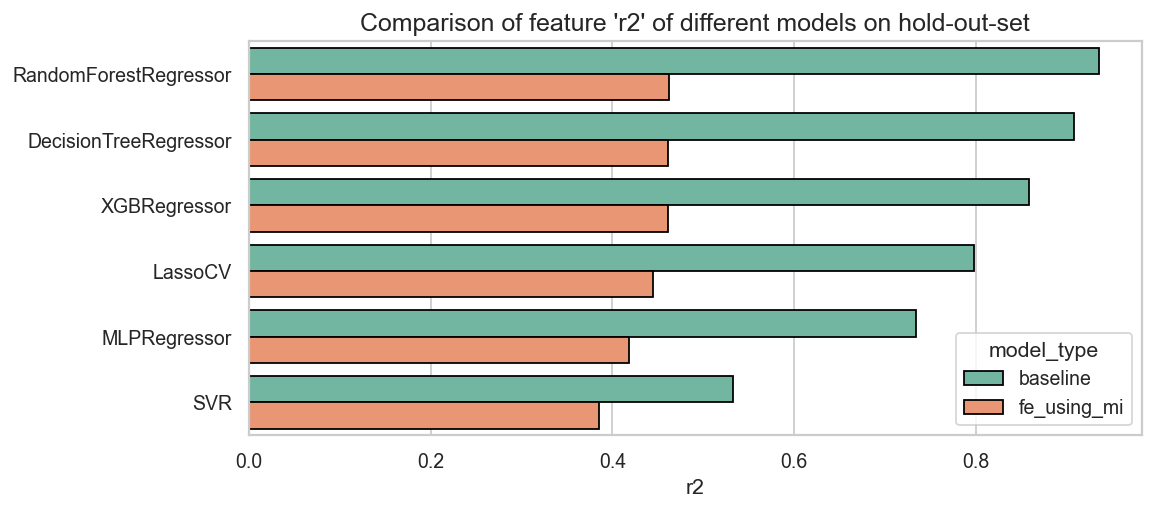

In [32]:
def stack_res_df(df1, df2) -> pd.DataFrame:
    res = pd.concat([df1, df2], axis=0)

    return res

res_overall = stack_res_df(df1=res, df2=res_fe)
plot_results(res_overall)